# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [ ]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import json
from pathlib import Path

## Session Management

Save/load your session to avoid re-registering.

In [ ]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [84]:
# Try to resume existing session
#client = load_session()
client = None

if not client:
    print("No saved session. Register below.")

No saved session. Register below.


## Step 1: Register

Skip this if you resumed a session above.

In [85]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()
    
    # CHANGE THESE to your unique values
    PLAYER_ID = "hello man"
    PLAYER_NAME = "995712"
    
    result = client.register(PLAYER_ID, PLAYER_NAME, location="in_person")
    
    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

Registered! Token: dF19TpehchOdr2cwn2Z_...

Starting candidates (4):
  - Rosario, Argentina: 3 qubits, +0 bonus
  - Accra, Ghana: 4 qubits, +0 bonus
  - Albuquerque, NM: 3 qubits, +0 bonus
  - Spokane, WA: 2 qubits, +0 bonus
Session saved.


## Step 2: Select Starting Node

In [86]:
status = client.get_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Accra, Ghana")
    print(result)

Select a starting node from the candidates shown above.
{'ok': True, 'data': {'success': True, 'starting_node': 'Accra, Ghana', 'score': 0, 'budget': 40}}


## Step 3: Explore the Network

In [31]:
client.print_status()

Player: 441146 (koiboi)
Score: 10 | Budget: 35 bell pairs
Active: Yes
Starting node: Las Vegas, NV
Owned: 2 nodes, 2 edges
Claimable edges: 10
  - ['Los Angeles, CA', 'Riverside, CA']: threshold=0.90, difficulty=1
  - ['Las Vegas, NV', 'Pasadena, CA']: threshold=0.90, difficulty=3
  - ['Bakersfield, CA', 'Las Vegas, NV']: threshold=0.90, difficulty=3
  ... and 7 more


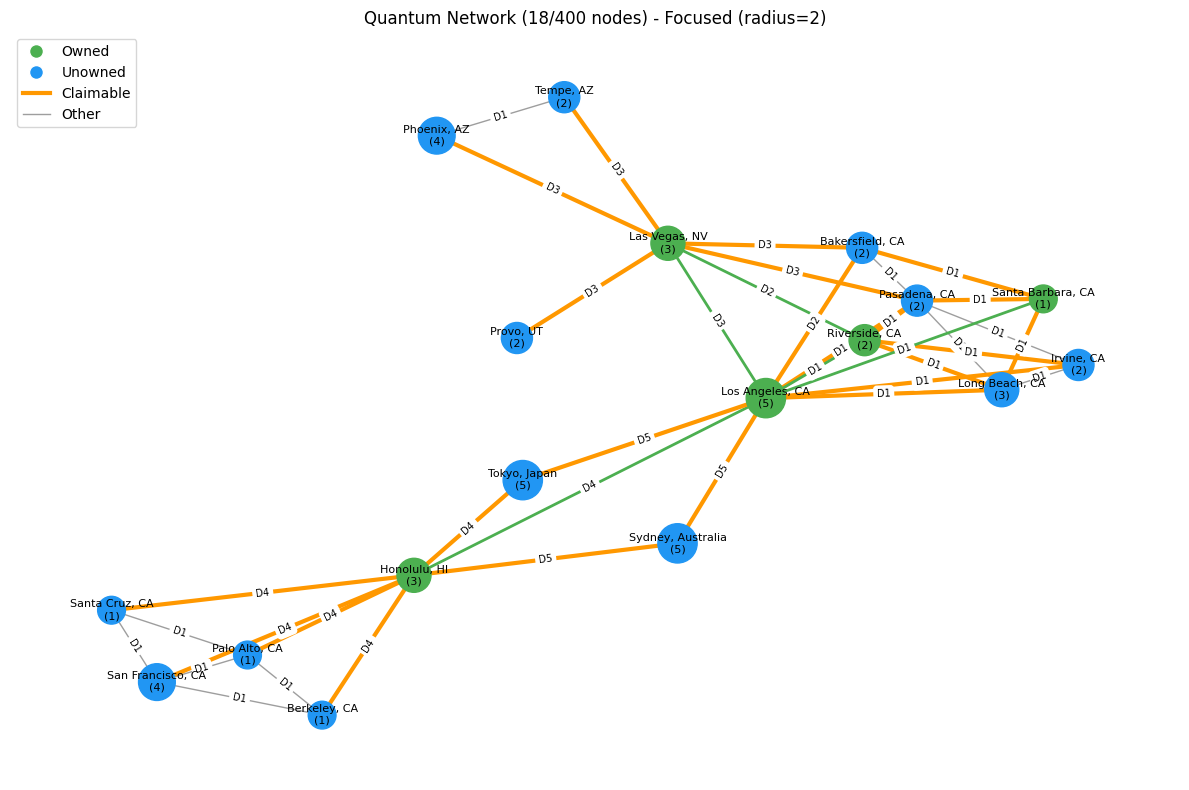

In [45]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

## Step 5: Claim an Edge

In [87]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:5]:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (4):
  ['Accra, Ghana', 'Lagos, Nigeria'] - threshold: 0.900, difficulty: 3
  ['Accra, Ghana', 'Dakar, Senegal'] - threshold: 0.920, difficulty: 4
  ['Accra, Ghana', 'Casablanca, Morocco'] - threshold: 0.920, difficulty: 4
  ['Accra, Ghana', 'Rabat, Morocco'] - threshold: 0.920, difficulty: 4


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_d5_dejmps_tree_N8():
    """
    N=8 => 16 qubits total
    Alice: q0..q7, Bob: q8..q15

    Game pairing outside-in:
      P0: (q0,q15)
      P1: (q1,q14)
      P2: (q2,q13)
      P3: (q3,q12)
      P4: (q4,q11)
      P5: (q5,q10)
      P6: (q6,q9)
      P7: (q7,q8)   <-- OUTPUT (middle two qubits)

    Protocol: 3-round DEJMPS-style recurrence (8->4->2->1)
      Round 1: (P0->P1), (P2->P3), (P4->P5), (P6->P7)
      Round 2: (P1->P3), (P5->P7)
      Round 3: (P3->P7)

    Keep rule each step: measure target pair in Z and require Alice_bit == Bob_bit.
    Flag bit is OR of all mismatches; server postselects flag==0.
    """

    qr = QuantumRegister(16, "q")
    cr = ClassicalRegister(64, "c")  # roomy

    qc = QuantumCircuit(qr, cr)

    # We'll use:
    # - measurement bits: c[0..13] (2 per step * 7 steps = 14)
    # - syndrome bits:    c[20..26] (1 per step * 7)
    # - flag bit:         c[63]
    m_base = 0
    s_base = 20
    FLAG   = 63

    # --- Clifford implementations of Rx(±pi/2) (up to global phase) ---
    # Rx(+pi/2) ~ H S H
    def rx_pio2(q):
        qc.h(q); qc.s(q); qc.h(q)

    # Rx(-pi/2) ~ H Sdg H
    def rx_mpio2(q):
        qc.h(q); qc.sdg(q); qc.h(q)

    def dejmps_step(keepA, keepB, targA, targB, step_idx):
        """
        DEJMPS-ish local rotations + bilateral CNOT + Z-measure targets, postselect on equality.

        Allowed ops:
          - rotations are single-qubit local
          - CNOTs only within Alice side (0..7) and within Bob side (8..15)

        Computes syndrome = meas(targA) XOR meas(targB)
        Updates FLAG = FLAG OR syndrome
        """
        m0 = m_base + 2*step_idx
        m1 = m0 + 1
        s  = s_base + step_idx

        # Local pre-rotations on BOTH pairs:
        # Alice qubits: Rx(+pi/2), Bob qubits: Rx(-pi/2)
        rx_pio2(qr[keepA]); rx_pio2(qr[targA])
        rx_mpio2(qr[keepB]); rx_mpio2(qr[targB])

        # Bilateral CNOT (keep -> target) within each side
        qc.cx(qr[keepA], qr[targA])   # Alice side
        qc.cx(qr[keepB], qr[targB])   # Bob side

        # Measure target qubits (Z basis)
        qc.measure(qr[targA], cr[m0])
        qc.measure(qr[targB], cr[m1])

        # syndrome = mismatch = mA XOR mB
        qc.store(cr[s], expr.bit_xor(cr[m0], cr[m1]))

        # FLAG = FLAG OR syndrome  (flag=1 means discard)
        qc.store(cr[FLAG], expr.bit_or(cr[FLAG], cr[s]))

        # Undo rotations on KEPT pair only (restore basis for subsequent rounds + final fidelity)
        # Inverses: Alice Rx(+pi/2)^{-1} = Rx(-pi/2), Bob Rx(-pi/2)^{-1} = Rx(+pi/2)
        rx_mpio2(qr[keepA])
        rx_pio2(qr[keepB])

    # Define pairs (Alice, Bob)
    P0 = (0, 15)
    P1 = (1, 14)
    P2 = (2, 13)
    P3 = (3, 12)
    P4 = (4, 11)
    P5 = (5, 10)
    P6 = (6,  9)
    P7 = (7,  8)   # output

    # Round 1 (4 steps)
    dejmps_step(P1[0], P1[1], P0[0], P0[1], step_idx=0)  # P0 -> P1
    dejmps_step(P3[0], P3[1], P2[0], P2[1], step_idx=1)  # P2 -> P3
    dejmps_step(P5[0], P5[1], P4[0], P4[1], step_idx=2)  # P4 -> P5
    dejmps_step(P7[0], P7[1], P6[0], P6[1], step_idx=3)  # P6 -> P7 (output location)

    # Round 2 (2 steps): P1 -> P3, and P5 -> P7
    dejmps_step(P3[0], P3[1], P1[0], P1[1], step_idx=4)
    dejmps_step(P7[0], P7[1], P5[0], P5[1], step_idx=5)

    # Round 3 (1 step): P3 -> P7
    dejmps_step(P7[0], P7[1], P3[0], P3[1], step_idx=6)

    # Output pair is (q7, q8). Postselect on FLAG==0.
    return qc, FLAG

def run_d5_n8_on_edge(client, source_city: str, target_city: str):
    claimable = client.get_claimable_edges()
    want = {source_city, target_city}
    target_edge = next((e for e in claimable if set(e["edge_id"]) == want), None)

    if target_edge is None:
        print(f"Edge {source_city} <-> {target_city} is NOT currently claimable.")
        for e in sorted(claimable, key=lambda x: (x["difficulty_rating"], x["base_threshold"]))[:12]:
            print(f"  {tuple(e['edge_id'])} | diff={e['difficulty_rating']} | thr={e['base_threshold']}")
        return None

    edge_id = tuple(target_edge["edge_id"])
    diff = int(target_edge.get("difficulty_rating", -1))
    thr  = float(target_edge.get("base_threshold", 0.0))
    print(f"Attacking edge: {edge_id} | diff={diff} | thr={thr:.2f}")

    circuit, flag_bit = get_d5_dejmps_tree_N8()

    result = client.claim_edge(
        edge=edge_id,
        circuit=circuit,
        flag_bit=int(flag_bit),   # <-- should be 63
        num_bell_pairs=8
    )

    if not result.get("ok"):
        print("FAILED:", result.get("error", {}).get("code"), "-", result.get("error", {}).get("message"))
        return result

    data = result["data"]
    F = float(data.get("fidelity", 0.0))
    p = float(data.get("success_probability", 0.0))
    print(f"Success: {data.get('success')}")
    print(f"Fidelity: {F:.4f} (threshold: {float(data.get('threshold', 0.0)):.4f})")
    print(f"Success probability: {p:.4f}")
    print(f"Claim strength added (f*p): {F*p:.4f}")

    return result


# ---- EDIT THESE ----
SOURCE = "Honolulu, HI"
TARGET = "Sydney, Australia"

run_d5_n8_on_edge(client, SOURCE, TARGET)

Edge Honolulu, HI <-> Sydney, Australia is NOT currently claimable.
Some claimable edges (first 12):
  ('Austin, TX', 'Waco, TX') | diff=1 | thr=0.9
  ('Austin, TX', 'Fort Worth, TX') | diff=2 | thr=0.9
  ('Dallas, TX', 'Fort Worth, TX') | diff=1 | thr=0.9
  ('Dallas, TX', 'Waco, TX') | diff=1 | thr=0.9
  ('Dallas, TX', 'Oklahoma City, OK') | diff=2 | thr=0.9
  ('Houston, TX', 'Waco, TX') | diff=2 | thr=0.9
  ('San Antonio, TX', 'Waco, TX') | diff=2 | thr=0.9
  ('Fort Worth, TX', 'San Antonio, TX') | diff=3 | thr=0.9
  ('Houston, TX', 'New Orleans, LA') | diff=3 | thr=0.9
  ('Baton Rouge, LA', 'Houston, TX') | diff=3 | thr=0.9
  ('Dallas, TX', 'Little Rock, AR') | diff=3 | thr=0.9
  ('Dallas, TX', 'Tulsa, OK') | diff=3 | thr=0.9


## Step 6: Check Progress

In [ ]:
client.print_status()

In [ ]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [ ]:
# Restart game (uncomment to use)
# result = client.restart()
# print(result)